# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

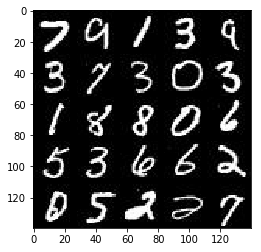

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

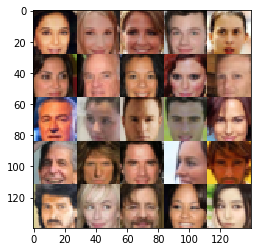

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learing_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        
        flats = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flats, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.01):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    width = data_shape[1]
    height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(width, height, image_channels , z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 50
    show_every = 100
    steps_per_epoch = data_shape[0]//batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}/{}...".format(steps - (epoch_i * steps_per_epoch), steps_per_epoch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 50/1875... Discriminator Loss: 0.5554... Generator Loss: 2.0785
Epoch 1/2... Step 100/1875... Discriminator Loss: 0.3773... Generator Loss: 4.0876


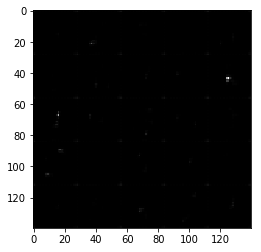

Epoch 1/2... Step 150/1875... Discriminator Loss: 0.3389... Generator Loss: 10.3927
Epoch 1/2... Step 200/1875... Discriminator Loss: 0.6291... Generator Loss: 2.2205


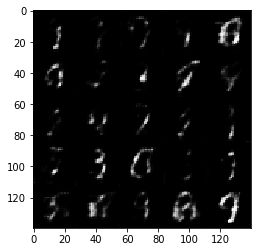

Epoch 1/2... Step 250/1875... Discriminator Loss: 0.3980... Generator Loss: 5.7685
Epoch 1/2... Step 300/1875... Discriminator Loss: 0.3414... Generator Loss: 5.3479


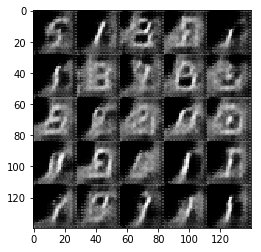

Epoch 1/2... Step 350/1875... Discriminator Loss: 1.4157... Generator Loss: 1.8836
Epoch 1/2... Step 400/1875... Discriminator Loss: 0.3709... Generator Loss: 4.5106


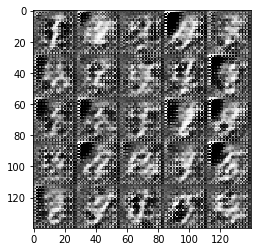

Epoch 1/2... Step 450/1875... Discriminator Loss: 0.3579... Generator Loss: 5.6035
Epoch 1/2... Step 500/1875... Discriminator Loss: 1.3811... Generator Loss: 5.0424


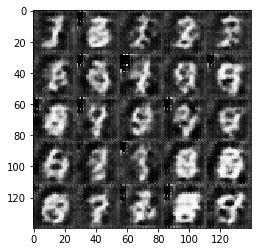

Epoch 1/2... Step 550/1875... Discriminator Loss: 0.3577... Generator Loss: 5.0432
Epoch 1/2... Step 600/1875... Discriminator Loss: 1.1575... Generator Loss: 3.4805


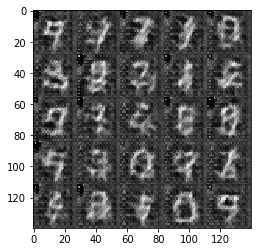

Epoch 1/2... Step 650/1875... Discriminator Loss: 0.4701... Generator Loss: 2.3101
Epoch 1/2... Step 700/1875... Discriminator Loss: 2.6645... Generator Loss: 0.1298


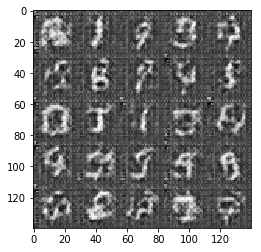

Epoch 1/2... Step 750/1875... Discriminator Loss: 0.3961... Generator Loss: 3.7371
Epoch 1/2... Step 800/1875... Discriminator Loss: 0.8778... Generator Loss: 1.0297


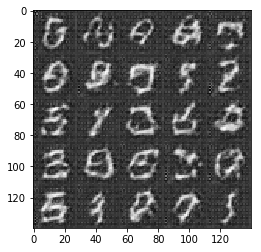

Epoch 1/2... Step 850/1875... Discriminator Loss: 0.8428... Generator Loss: 1.3946
Epoch 1/2... Step 900/1875... Discriminator Loss: 3.3848... Generator Loss: 2.9611


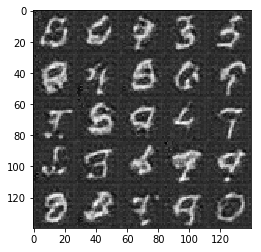

Epoch 1/2... Step 950/1875... Discriminator Loss: 0.8119... Generator Loss: 1.2234
Epoch 1/2... Step 1000/1875... Discriminator Loss: 0.4879... Generator Loss: 2.4480


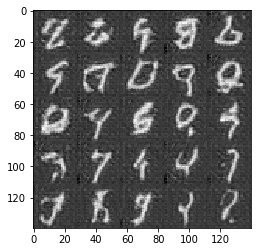

Epoch 1/2... Step 1050/1875... Discriminator Loss: 0.4126... Generator Loss: 3.1672
Epoch 1/2... Step 1100/1875... Discriminator Loss: 1.1347... Generator Loss: 0.7447


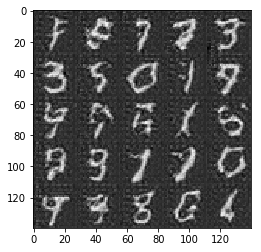

Epoch 1/2... Step 1150/1875... Discriminator Loss: 0.5429... Generator Loss: 4.6197
Epoch 1/2... Step 1200/1875... Discriminator Loss: 0.3461... Generator Loss: 5.2911


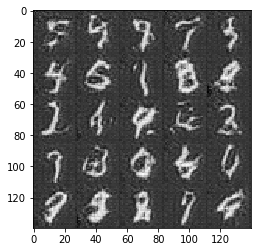

Epoch 1/2... Step 1250/1875... Discriminator Loss: 2.1935... Generator Loss: 3.1473
Epoch 1/2... Step 1300/1875... Discriminator Loss: 0.8742... Generator Loss: 1.2962


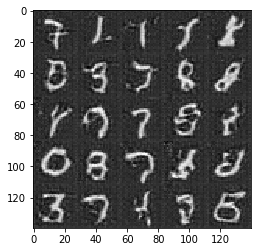

Epoch 1/2... Step 1350/1875... Discriminator Loss: 1.5035... Generator Loss: 0.4497
Epoch 1/2... Step 1400/1875... Discriminator Loss: 2.1007... Generator Loss: 0.2159


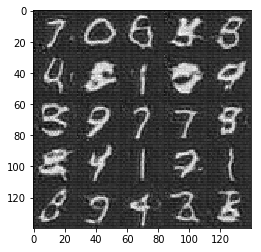

Epoch 1/2... Step 1450/1875... Discriminator Loss: 0.5847... Generator Loss: 2.1148
Epoch 1/2... Step 1500/1875... Discriminator Loss: 0.5915... Generator Loss: 1.7423


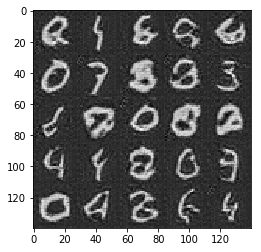

Epoch 1/2... Step 1550/1875... Discriminator Loss: 0.8658... Generator Loss: 1.1851
Epoch 1/2... Step 1600/1875... Discriminator Loss: 1.1743... Generator Loss: 2.2490


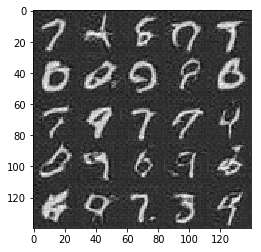

Epoch 1/2... Step 1650/1875... Discriminator Loss: 2.0344... Generator Loss: 0.3301
Epoch 1/2... Step 1700/1875... Discriminator Loss: 0.5024... Generator Loss: 2.7025


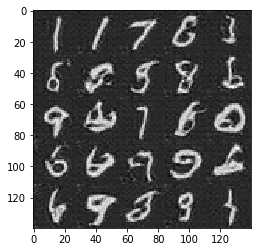

Epoch 1/2... Step 1750/1875... Discriminator Loss: 1.2849... Generator Loss: 3.1786
Epoch 1/2... Step 1800/1875... Discriminator Loss: 1.0673... Generator Loss: 1.0542


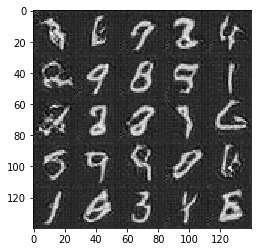

Epoch 1/2... Step 1850/1875... Discriminator Loss: 0.5809... Generator Loss: 2.2700
Epoch 2/2... Step 25/1875... Discriminator Loss: 1.0339... Generator Loss: 0.8921


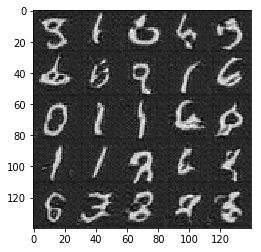

Epoch 2/2... Step 75/1875... Discriminator Loss: 0.6756... Generator Loss: 2.3484
Epoch 2/2... Step 125/1875... Discriminator Loss: 1.0006... Generator Loss: 0.9437


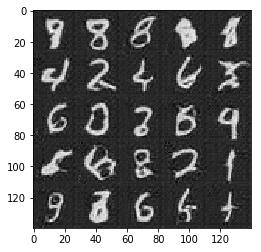

Epoch 2/2... Step 175/1875... Discriminator Loss: 1.4082... Generator Loss: 0.5570
Epoch 2/2... Step 225/1875... Discriminator Loss: 0.9406... Generator Loss: 1.0185


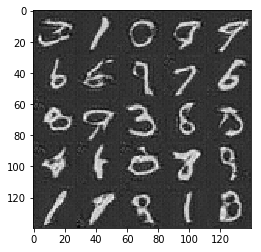

Epoch 2/2... Step 275/1875... Discriminator Loss: 0.4912... Generator Loss: 2.2699
Epoch 2/2... Step 325/1875... Discriminator Loss: 0.8437... Generator Loss: 1.1098


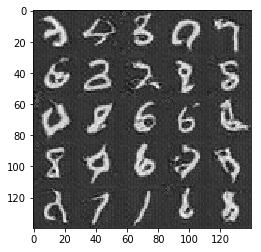

Epoch 2/2... Step 375/1875... Discriminator Loss: 1.1944... Generator Loss: 0.6575
Epoch 2/2... Step 425/1875... Discriminator Loss: 1.6830... Generator Loss: 0.4481


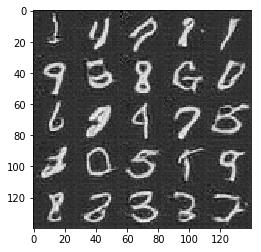

Epoch 2/2... Step 475/1875... Discriminator Loss: 2.2060... Generator Loss: 0.2974
Epoch 2/2... Step 525/1875... Discriminator Loss: 1.2600... Generator Loss: 0.7318


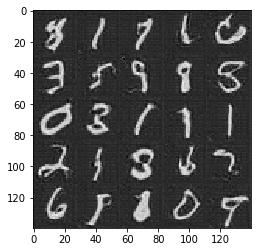

Epoch 2/2... Step 575/1875... Discriminator Loss: 1.1611... Generator Loss: 0.7421
Epoch 2/2... Step 625/1875... Discriminator Loss: 0.8584... Generator Loss: 1.2575


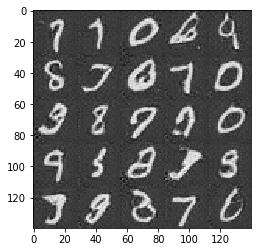

Epoch 2/2... Step 675/1875... Discriminator Loss: 0.6843... Generator Loss: 2.0687
Epoch 2/2... Step 725/1875... Discriminator Loss: 0.9033... Generator Loss: 0.9668


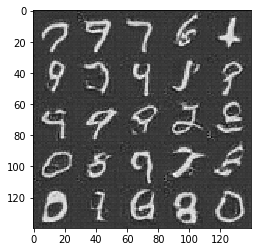

Epoch 2/2... Step 775/1875... Discriminator Loss: 0.9551... Generator Loss: 1.1540
Epoch 2/2... Step 825/1875... Discriminator Loss: 0.5913... Generator Loss: 2.3157


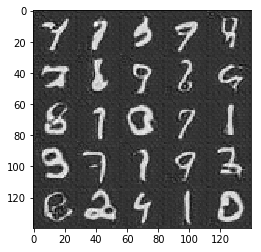

Epoch 2/2... Step 875/1875... Discriminator Loss: 0.6096... Generator Loss: 3.3459
Epoch 2/2... Step 925/1875... Discriminator Loss: 1.1833... Generator Loss: 0.7219


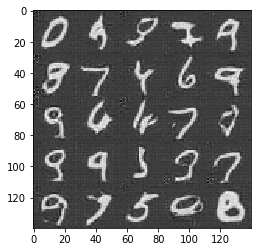

Epoch 2/2... Step 975/1875... Discriminator Loss: 0.4556... Generator Loss: 2.8287
Epoch 2/2... Step 1025/1875... Discriminator Loss: 0.4597... Generator Loss: 2.6005


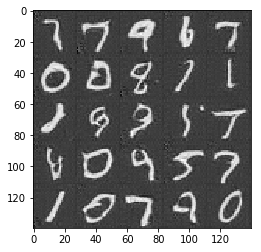

Epoch 2/2... Step 1075/1875... Discriminator Loss: 0.4957... Generator Loss: 2.7691
Epoch 2/2... Step 1125/1875... Discriminator Loss: 1.0525... Generator Loss: 0.9152


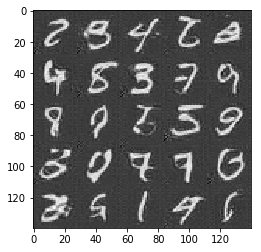

Epoch 2/2... Step 1175/1875... Discriminator Loss: 0.7349... Generator Loss: 1.3746
Epoch 2/2... Step 1225/1875... Discriminator Loss: 0.7835... Generator Loss: 1.2701


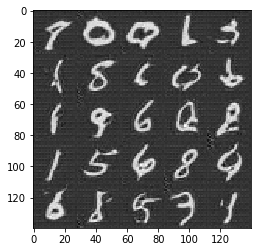

Epoch 2/2... Step 1275/1875... Discriminator Loss: 1.3832... Generator Loss: 0.6172
Epoch 2/2... Step 1325/1875... Discriminator Loss: 1.5265... Generator Loss: 0.4244


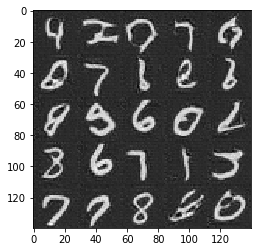

Epoch 2/2... Step 1375/1875... Discriminator Loss: 0.8840... Generator Loss: 1.1218
Epoch 2/2... Step 1425/1875... Discriminator Loss: 1.4449... Generator Loss: 0.6002


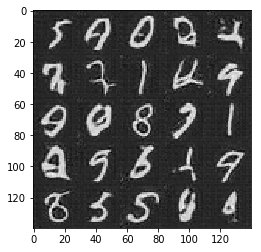

Epoch 2/2... Step 1475/1875... Discriminator Loss: 0.4205... Generator Loss: 3.3996
Epoch 2/2... Step 1525/1875... Discriminator Loss: 1.7113... Generator Loss: 0.4406


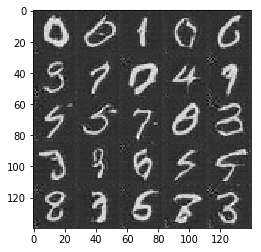

Epoch 2/2... Step 1575/1875... Discriminator Loss: 1.3731... Generator Loss: 0.5876
Epoch 2/2... Step 1625/1875... Discriminator Loss: 0.8049... Generator Loss: 1.3721


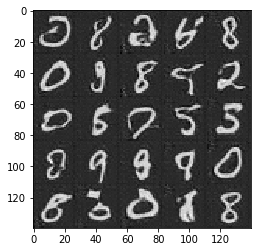

Epoch 2/2... Step 1675/1875... Discriminator Loss: 0.5372... Generator Loss: 2.2259
Epoch 2/2... Step 1725/1875... Discriminator Loss: 2.1305... Generator Loss: 0.3555


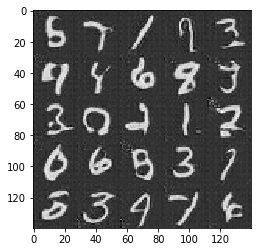

Epoch 2/2... Step 1775/1875... Discriminator Loss: 1.3056... Generator Loss: 0.5771
Epoch 2/2... Step 1825/1875... Discriminator Loss: 0.8294... Generator Loss: 1.1434


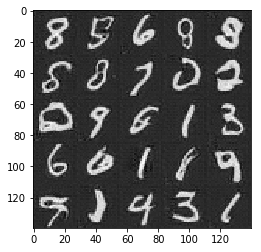

Epoch 2/2... Step 1875/1875... Discriminator Loss: 1.1819... Generator Loss: 0.8830


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    mnist_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
                         mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 50/6331... Discriminator Loss: 0.7537... Generator Loss: 4.8504
Epoch 1/1... Step 100/6331... Discriminator Loss: 0.4459... Generator Loss: 3.0925


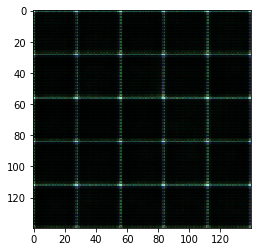

Epoch 1/1... Step 150/6331... Discriminator Loss: 0.3702... Generator Loss: 3.7576
Epoch 1/1... Step 200/6331... Discriminator Loss: 0.3425... Generator Loss: 5.5520


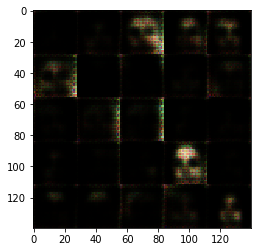

Epoch 1/1... Step 250/6331... Discriminator Loss: 0.4191... Generator Loss: 2.9814
Epoch 1/1... Step 300/6331... Discriminator Loss: 0.3999... Generator Loss: 5.1212


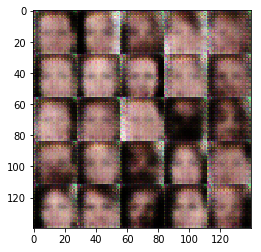

Epoch 1/1... Step 350/6331... Discriminator Loss: 0.3835... Generator Loss: 5.9369
Epoch 1/1... Step 400/6331... Discriminator Loss: 0.4000... Generator Loss: 10.5633


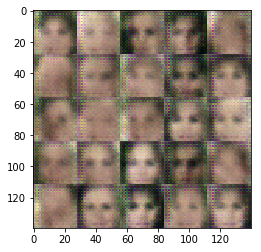

Epoch 1/1... Step 450/6331... Discriminator Loss: 0.4009... Generator Loss: 3.1810
Epoch 1/1... Step 500/6331... Discriminator Loss: 0.3656... Generator Loss: 7.9191


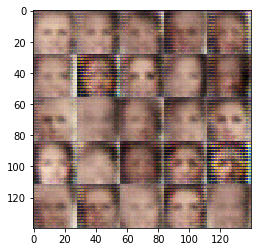

Epoch 1/1... Step 550/6331... Discriminator Loss: 0.3639... Generator Loss: 8.0945
Epoch 1/1... Step 600/6331... Discriminator Loss: 0.3619... Generator Loss: 4.4736


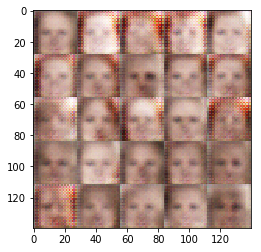

Epoch 1/1... Step 650/6331... Discriminator Loss: 0.7776... Generator Loss: 4.2951
Epoch 1/1... Step 700/6331... Discriminator Loss: 0.6753... Generator Loss: 4.7562


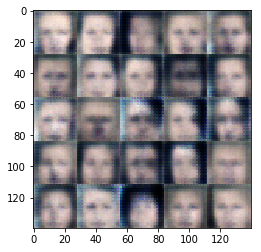

Epoch 1/1... Step 750/6331... Discriminator Loss: 0.4050... Generator Loss: 3.2874
Epoch 1/1... Step 800/6331... Discriminator Loss: 0.5010... Generator Loss: 2.3298


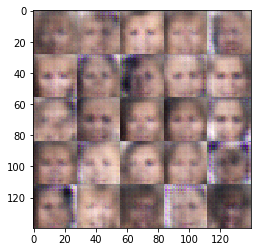

Epoch 1/1... Step 850/6331... Discriminator Loss: 0.3366... Generator Loss: 7.0338
Epoch 1/1... Step 900/6331... Discriminator Loss: 0.3453... Generator Loss: 5.1998


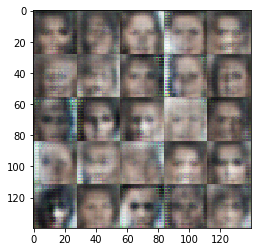

Epoch 1/1... Step 950/6331... Discriminator Loss: 0.4525... Generator Loss: 4.2197
Epoch 1/1... Step 1000/6331... Discriminator Loss: 0.4361... Generator Loss: 3.3797


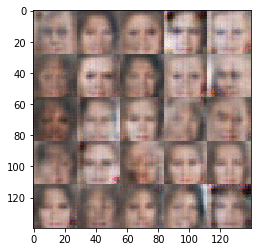

Epoch 1/1... Step 1050/6331... Discriminator Loss: 0.7659... Generator Loss: 1.3654
Epoch 1/1... Step 1100/6331... Discriminator Loss: 0.3610... Generator Loss: 4.5338


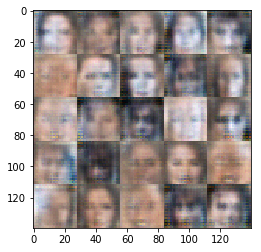

Epoch 1/1... Step 1150/6331... Discriminator Loss: 0.4617... Generator Loss: 4.6430
Epoch 1/1... Step 1200/6331... Discriminator Loss: 0.3751... Generator Loss: 4.0853


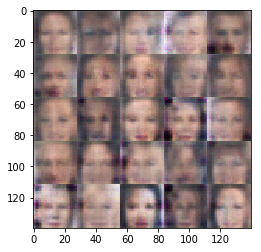

Epoch 1/1... Step 1250/6331... Discriminator Loss: 0.4639... Generator Loss: 2.5349
Epoch 1/1... Step 1300/6331... Discriminator Loss: 0.3426... Generator Loss: 8.3053


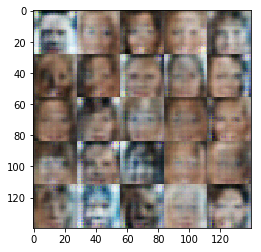

Epoch 1/1... Step 1350/6331... Discriminator Loss: 0.4938... Generator Loss: 4.9709
Epoch 1/1... Step 1400/6331... Discriminator Loss: 0.6941... Generator Loss: 1.9223


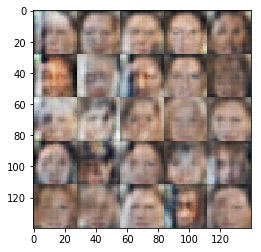

Epoch 1/1... Step 1450/6331... Discriminator Loss: 0.3798... Generator Loss: 4.4073
Epoch 1/1... Step 1500/6331... Discriminator Loss: 1.0471... Generator Loss: 1.1830


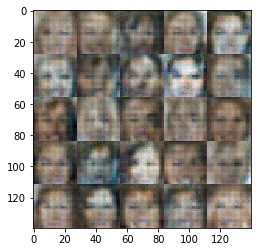

Epoch 1/1... Step 1550/6331... Discriminator Loss: 0.9432... Generator Loss: 1.4014
Epoch 1/1... Step 1600/6331... Discriminator Loss: 1.0784... Generator Loss: 1.0126


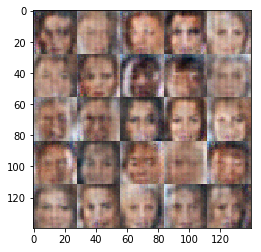

Epoch 1/1... Step 1650/6331... Discriminator Loss: 0.8233... Generator Loss: 1.3298
Epoch 1/1... Step 1700/6331... Discriminator Loss: 0.8731... Generator Loss: 1.0327


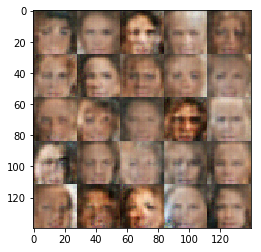

Epoch 1/1... Step 1750/6331... Discriminator Loss: 0.9668... Generator Loss: 1.1925
Epoch 1/1... Step 1800/6331... Discriminator Loss: 0.9865... Generator Loss: 0.9823


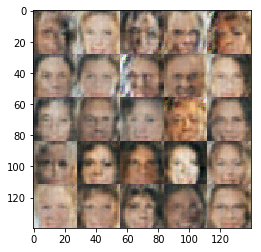

Epoch 1/1... Step 1850/6331... Discriminator Loss: 1.1262... Generator Loss: 0.7645
Epoch 1/1... Step 1900/6331... Discriminator Loss: 0.9897... Generator Loss: 1.0092


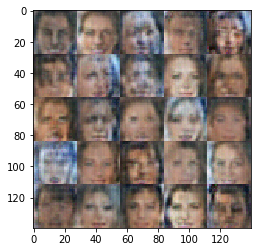

Epoch 1/1... Step 1950/6331... Discriminator Loss: 0.6101... Generator Loss: 1.8168
Epoch 1/1... Step 2000/6331... Discriminator Loss: 1.0538... Generator Loss: 1.1814


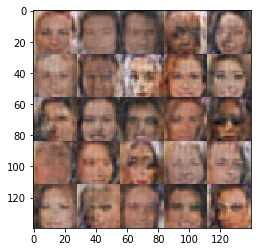

Epoch 1/1... Step 2050/6331... Discriminator Loss: 0.9297... Generator Loss: 3.3003
Epoch 1/1... Step 2100/6331... Discriminator Loss: 0.9948... Generator Loss: 0.9526


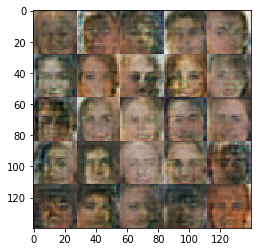

Epoch 1/1... Step 2150/6331... Discriminator Loss: 1.1522... Generator Loss: 0.8189
Epoch 1/1... Step 2200/6331... Discriminator Loss: 0.9725... Generator Loss: 1.0427


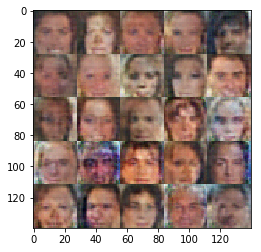

Epoch 1/1... Step 2250/6331... Discriminator Loss: 1.3630... Generator Loss: 0.5118
Epoch 1/1... Step 2300/6331... Discriminator Loss: 0.9181... Generator Loss: 1.1441


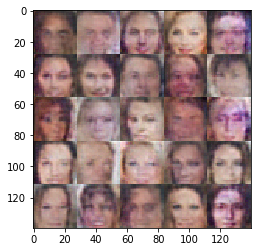

Epoch 1/1... Step 2350/6331... Discriminator Loss: 1.4646... Generator Loss: 0.4842
Epoch 1/1... Step 2400/6331... Discriminator Loss: 1.1629... Generator Loss: 0.9424


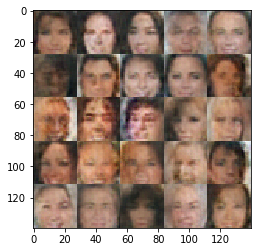

Epoch 1/1... Step 2450/6331... Discriminator Loss: 1.2592... Generator Loss: 0.6748
Epoch 1/1... Step 2500/6331... Discriminator Loss: 0.6392... Generator Loss: 1.7887


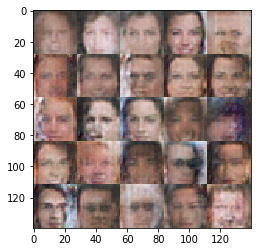

Epoch 1/1... Step 2550/6331... Discriminator Loss: 1.1751... Generator Loss: 0.8567
Epoch 1/1... Step 2600/6331... Discriminator Loss: 1.1024... Generator Loss: 0.8201


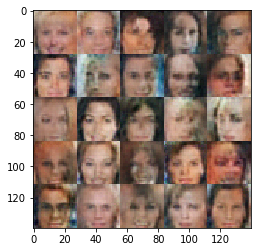

Epoch 1/1... Step 2650/6331... Discriminator Loss: 1.8126... Generator Loss: 0.3351
Epoch 1/1... Step 2700/6331... Discriminator Loss: 1.0796... Generator Loss: 1.0617


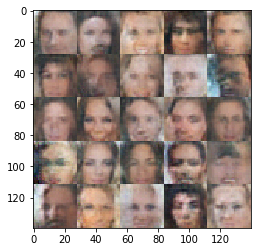

Epoch 1/1... Step 2750/6331... Discriminator Loss: 1.1812... Generator Loss: 0.6795
Epoch 1/1... Step 2800/6331... Discriminator Loss: 0.7433... Generator Loss: 1.3764


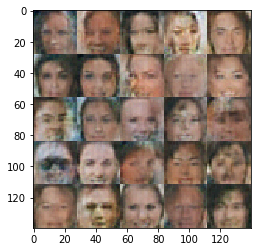

Epoch 1/1... Step 2850/6331... Discriminator Loss: 1.3008... Generator Loss: 0.5993
Epoch 1/1... Step 2900/6331... Discriminator Loss: 1.1260... Generator Loss: 0.9904


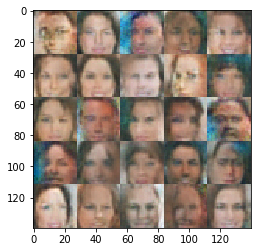

Epoch 1/1... Step 2950/6331... Discriminator Loss: 1.1168... Generator Loss: 0.7179
Epoch 1/1... Step 3000/6331... Discriminator Loss: 1.7059... Generator Loss: 0.3449


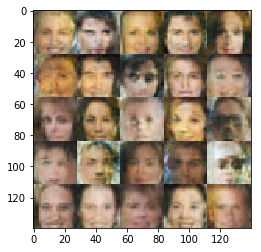

Epoch 1/1... Step 3050/6331... Discriminator Loss: 1.3140... Generator Loss: 0.9837
Epoch 1/1... Step 3100/6331... Discriminator Loss: 1.8136... Generator Loss: 0.3413


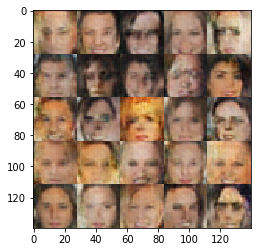

Epoch 1/1... Step 3150/6331... Discriminator Loss: 1.8890... Generator Loss: 0.2875
Epoch 1/1... Step 3200/6331... Discriminator Loss: 1.1274... Generator Loss: 0.9834


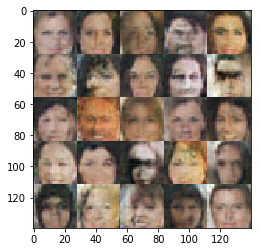

Epoch 1/1... Step 3250/6331... Discriminator Loss: 1.9370... Generator Loss: 0.2695
Epoch 1/1... Step 3300/6331... Discriminator Loss: 1.2628... Generator Loss: 0.6046


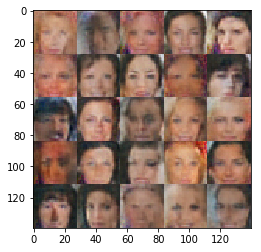

Epoch 1/1... Step 3350/6331... Discriminator Loss: 1.1560... Generator Loss: 0.8094
Epoch 1/1... Step 3400/6331... Discriminator Loss: 1.0904... Generator Loss: 0.7389


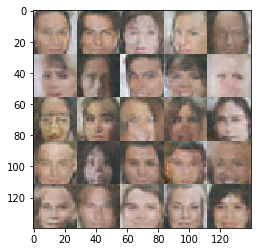

Epoch 1/1... Step 3450/6331... Discriminator Loss: 1.1313... Generator Loss: 0.7367
Epoch 1/1... Step 3500/6331... Discriminator Loss: 1.1701... Generator Loss: 0.8734


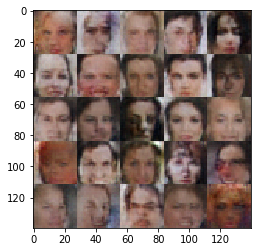

Epoch 1/1... Step 3550/6331... Discriminator Loss: 1.6499... Generator Loss: 0.4504
Epoch 1/1... Step 3600/6331... Discriminator Loss: 1.6127... Generator Loss: 0.3709


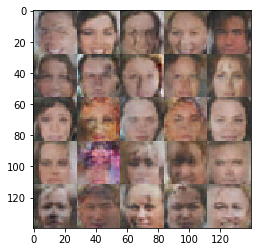

Epoch 1/1... Step 3650/6331... Discriminator Loss: 1.1782... Generator Loss: 0.7738
Epoch 1/1... Step 3700/6331... Discriminator Loss: 1.1579... Generator Loss: 0.8825


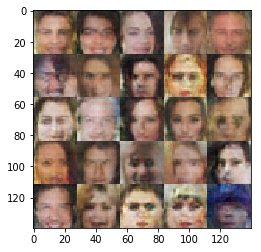

Epoch 1/1... Step 3750/6331... Discriminator Loss: 1.6636... Generator Loss: 0.3708
Epoch 1/1... Step 3800/6331... Discriminator Loss: 1.5391... Generator Loss: 0.4913


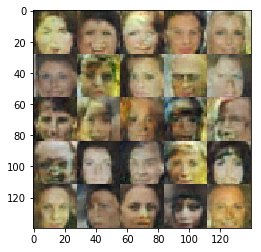

Epoch 1/1... Step 3850/6331... Discriminator Loss: 1.6642... Generator Loss: 0.4105
Epoch 1/1... Step 3900/6331... Discriminator Loss: 1.6001... Generator Loss: 0.3886


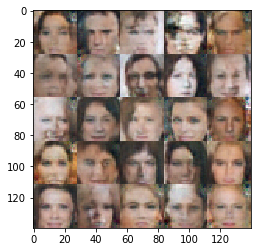

Epoch 1/1... Step 3950/6331... Discriminator Loss: 1.7000... Generator Loss: 0.4004
Epoch 1/1... Step 4000/6331... Discriminator Loss: 1.8405... Generator Loss: 0.2823


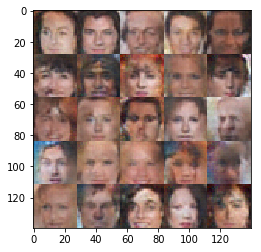

Epoch 1/1... Step 4050/6331... Discriminator Loss: 1.9615... Generator Loss: 0.2959
Epoch 1/1... Step 4100/6331... Discriminator Loss: 1.7036... Generator Loss: 0.3784


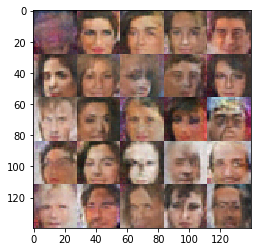

Epoch 1/1... Step 4150/6331... Discriminator Loss: 1.8231... Generator Loss: 0.2858
Epoch 1/1... Step 4200/6331... Discriminator Loss: 1.5851... Generator Loss: 0.4808


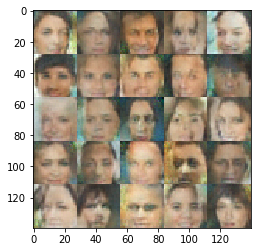

Epoch 1/1... Step 4250/6331... Discriminator Loss: 1.3347... Generator Loss: 0.5514
Epoch 1/1... Step 4300/6331... Discriminator Loss: 1.4622... Generator Loss: 0.5302


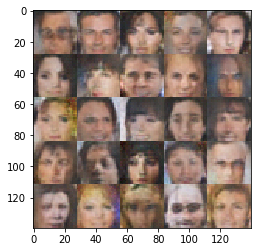

Epoch 1/1... Step 4350/6331... Discriminator Loss: 1.7975... Generator Loss: 0.3391
Epoch 1/1... Step 4400/6331... Discriminator Loss: 1.7132... Generator Loss: 0.3842


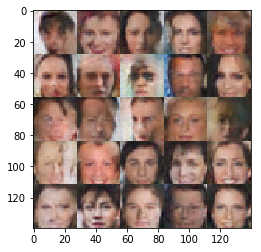

Epoch 1/1... Step 4450/6331... Discriminator Loss: 1.9577... Generator Loss: 0.2508
Epoch 1/1... Step 4500/6331... Discriminator Loss: 1.7484... Generator Loss: 0.3604


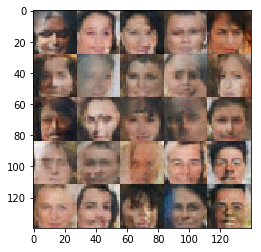

Epoch 1/1... Step 4550/6331... Discriminator Loss: 1.8110... Generator Loss: 0.2981
Epoch 1/1... Step 4600/6331... Discriminator Loss: 1.8521... Generator Loss: 0.2766


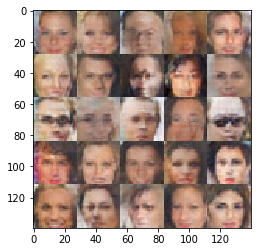

Epoch 1/1... Step 4650/6331... Discriminator Loss: 1.2793... Generator Loss: 0.6466
Epoch 1/1... Step 4700/6331... Discriminator Loss: 1.6057... Generator Loss: 0.3752


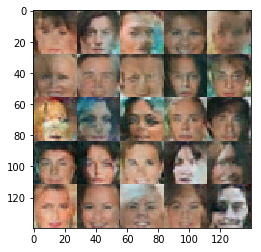

Epoch 1/1... Step 4750/6331... Discriminator Loss: 1.7842... Generator Loss: 1.0334
Epoch 1/1... Step 4800/6331... Discriminator Loss: 1.5359... Generator Loss: 0.5997


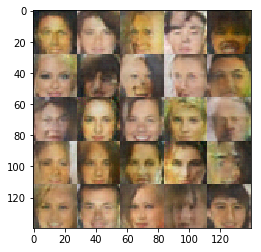

Epoch 1/1... Step 4850/6331... Discriminator Loss: 1.2083... Generator Loss: 0.7692
Epoch 1/1... Step 4900/6331... Discriminator Loss: 1.2994... Generator Loss: 0.6001


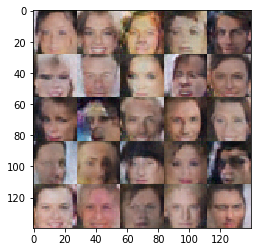

Epoch 1/1... Step 4950/6331... Discriminator Loss: 2.2660... Generator Loss: 0.1811
Epoch 1/1... Step 5000/6331... Discriminator Loss: 1.5500... Generator Loss: 0.3836


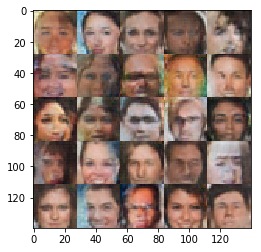

Epoch 1/1... Step 5050/6331... Discriminator Loss: 1.0991... Generator Loss: 0.8109
Epoch 1/1... Step 5100/6331... Discriminator Loss: 1.3870... Generator Loss: 0.5915


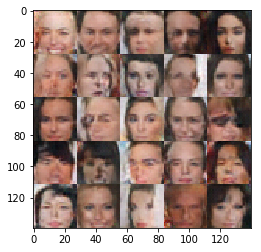

Epoch 1/1... Step 5150/6331... Discriminator Loss: 1.2228... Generator Loss: 0.6216
Epoch 1/1... Step 5200/6331... Discriminator Loss: 1.5463... Generator Loss: 0.4595


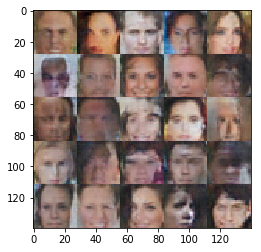

Epoch 1/1... Step 5250/6331... Discriminator Loss: 1.8142... Generator Loss: 0.3499
Epoch 1/1... Step 5300/6331... Discriminator Loss: 0.9927... Generator Loss: 1.0136


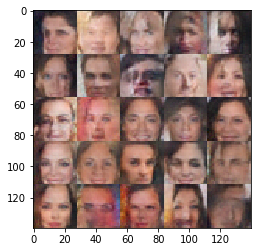

Epoch 1/1... Step 5350/6331... Discriminator Loss: 0.9861... Generator Loss: 1.3036
Epoch 1/1... Step 5400/6331... Discriminator Loss: 1.3010... Generator Loss: 0.6660


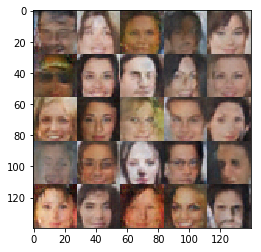

Epoch 1/1... Step 5450/6331... Discriminator Loss: 1.8821... Generator Loss: 0.3370
Epoch 1/1... Step 5500/6331... Discriminator Loss: 1.7635... Generator Loss: 0.3428


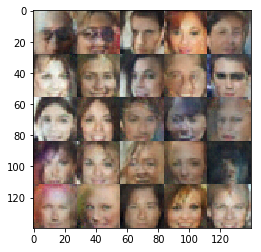

Epoch 1/1... Step 5550/6331... Discriminator Loss: 2.7956... Generator Loss: 0.1168
Epoch 1/1... Step 5600/6331... Discriminator Loss: 1.5878... Generator Loss: 0.4123


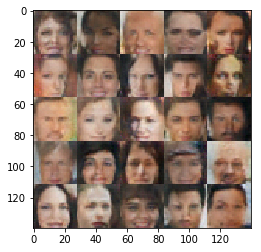

Epoch 1/1... Step 5650/6331... Discriminator Loss: 1.6644... Generator Loss: 0.3530
Epoch 1/1... Step 5700/6331... Discriminator Loss: 1.6163... Generator Loss: 0.4318


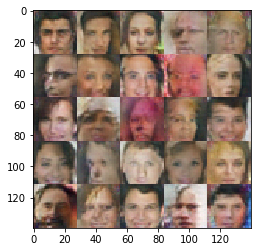

Epoch 1/1... Step 5750/6331... Discriminator Loss: 1.5293... Generator Loss: 0.4421
Epoch 1/1... Step 5800/6331... Discriminator Loss: 1.2729... Generator Loss: 0.5922


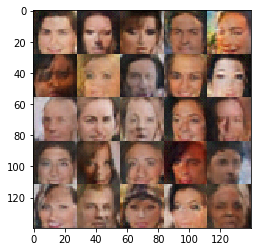

Epoch 1/1... Step 5850/6331... Discriminator Loss: 1.4541... Generator Loss: 0.5156
Epoch 1/1... Step 5900/6331... Discriminator Loss: 1.6639... Generator Loss: 0.3710


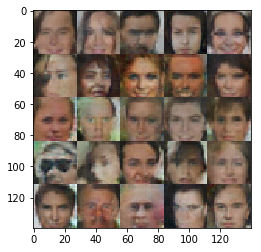

Epoch 1/1... Step 5950/6331... Discriminator Loss: 1.4143... Generator Loss: 0.5048
Epoch 1/1... Step 6000/6331... Discriminator Loss: 1.1718... Generator Loss: 0.8807


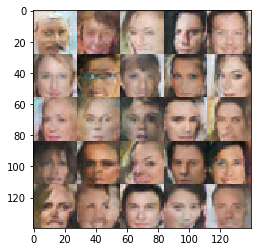

Epoch 1/1... Step 6050/6331... Discriminator Loss: 1.8505... Generator Loss: 0.2912
Epoch 1/1... Step 6100/6331... Discriminator Loss: 1.7616... Generator Loss: 0.3607


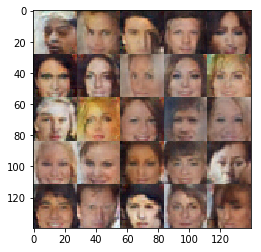

Epoch 1/1... Step 6150/6331... Discriminator Loss: 1.4340... Generator Loss: 0.5073
Epoch 1/1... Step 6200/6331... Discriminator Loss: 1.6100... Generator Loss: 0.4443


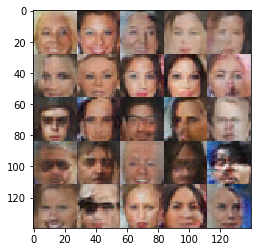

Epoch 1/1... Step 6250/6331... Discriminator Loss: 1.9731... Generator Loss: 0.2899


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    celeba_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
                          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.